# Master Thesis Notebook

## Setup

In [3]:
# Importation of the classes and methods associated
from classes import *

## GPR VWC Analysis

### Raw data

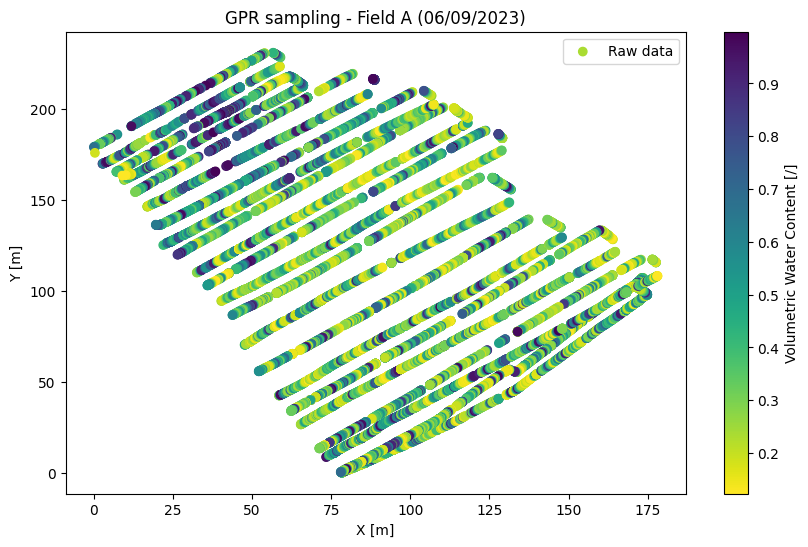

In [4]:
# Instance creation
gpr_a = GprAnalysis(field_paths=GprAnalysis.FIELD_A_PATHS, sample_number=4)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_a.plot_raw_data(plot=True)

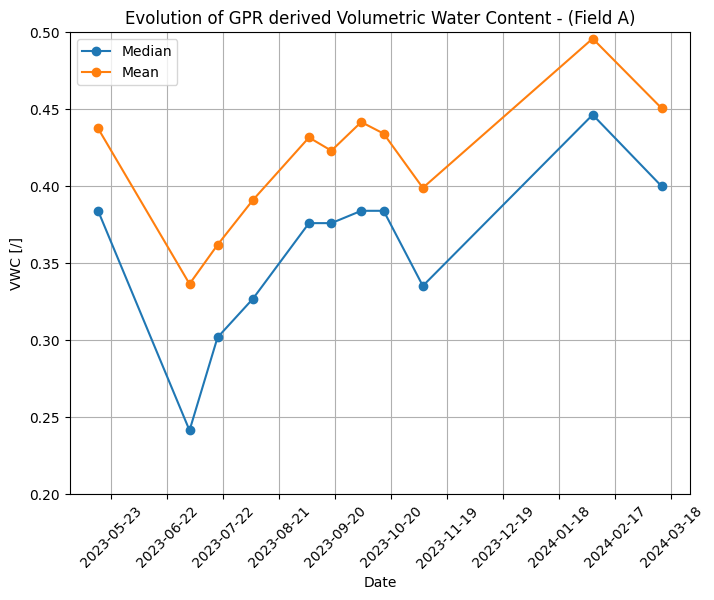

In [5]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

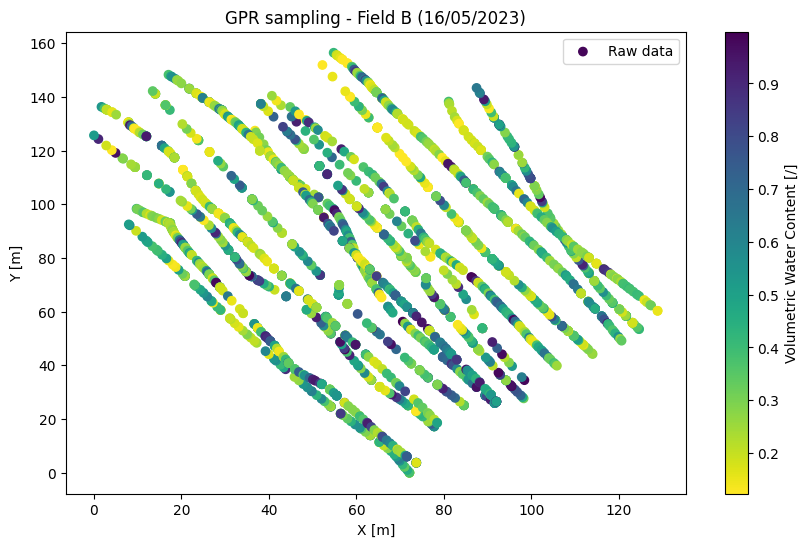

In [6]:
# Instance creation
gpr_b = GprAnalysis(field_paths=GprAnalysis.FIELD_B_PATHS, sample_number=0)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_b.plot_raw_data(plot=True)

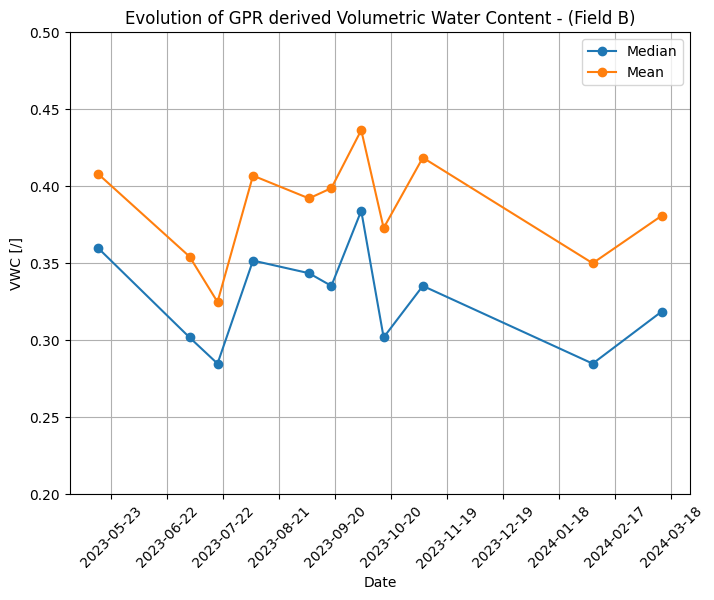

In [7]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

### Choosing the variogram model

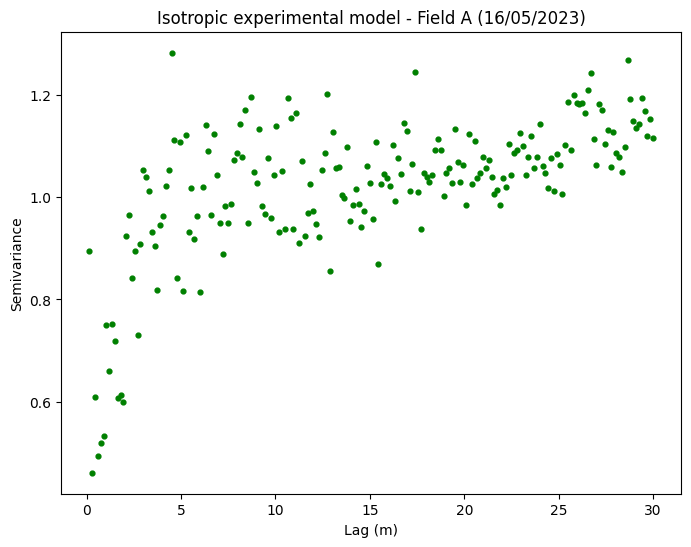

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999972,  0.29999944,  0.44999916,  0.59999888,  0.74999861,
         0.89999833,  1.04999805,  1.19999777,  1.34999749,  1.49999721,
         1.64999693,  1.79999665,  1.94999638,  2.0999961 ,  2.24999582,
         2.39999554,  2.54999526,  2.69999498,  2.8499947 ,  2.99999442,
         3.14999414,  3.29999387,  3.44999359,  3.59999331,  3.74999303,
         3.89999275,  4.04999247,  4.19999219,  4.34999191,  4.49999163,
         4.64999136,  4.79999108,  4.9499908 ,  5.09999052,  5.24999024,
         5.39998996,  5.54998968,  5.6999894 ,  5.84998913,  5.99998885,
         6.14998857,  6.29998829,  6.44998801,  6.59998773,  6.74998745,
         6.89998717,  7.04998689,  7.19998662,  7.34998634,  7.49998606,
         7.64998578,  7.7999855 ,  7.94998522,  8.09998494,  8.24998466,
         8.39998438,  8.54998411,  8.69998383,  8.84998355,  8.99998327,
         9.14998299,  9.29998271,  9.44998243,  9.59998215,  9.74998188,
  

In [8]:
experimental_vario_a = Variogram(resolution=0.00002, field_paths=GprAnalysis.FIELD_A_PATHS, sample_number=0)

experimental_vario_a.determ_experimental_vario()
# ; hide output of the cell

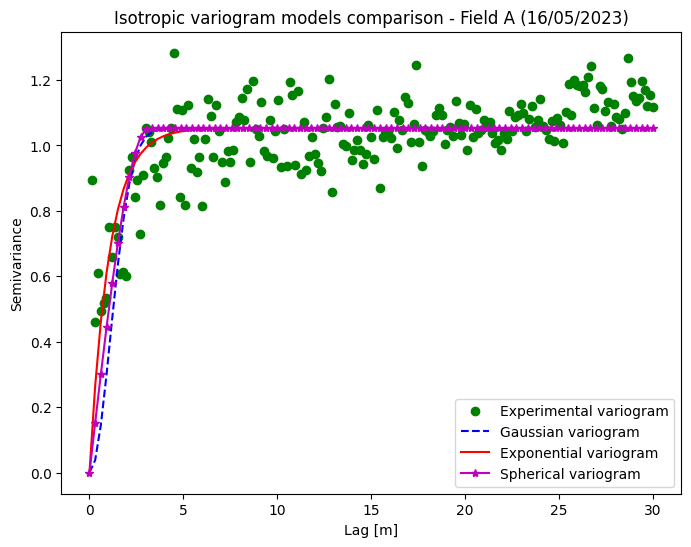

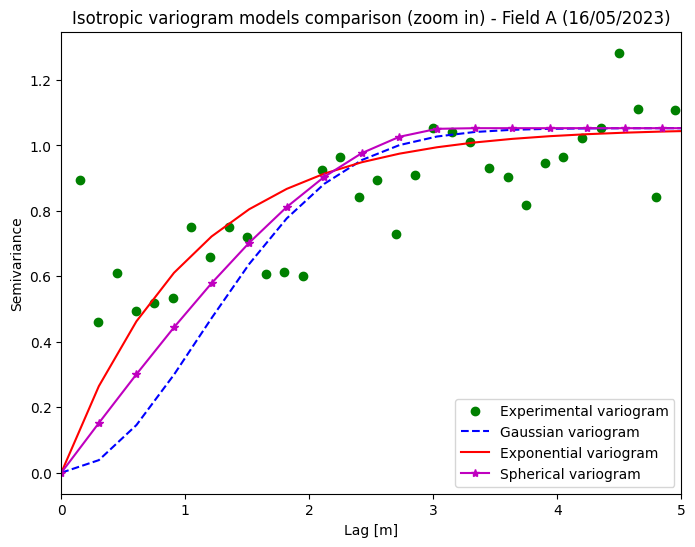

In [9]:
experimental_vario_a.fit_models()

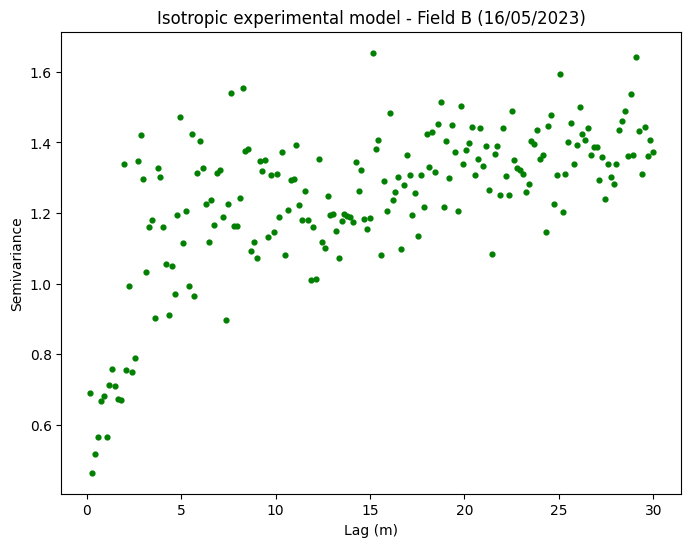

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999968,  0.29999935,  0.44999903,  0.59999871,  0.74999839,
         0.89999806,  1.04999774,  1.19999742,  1.34999709,  1.49999677,
         1.64999645,  1.79999612,  1.9499958 ,  2.09999548,  2.24999516,
         2.39999483,  2.54999451,  2.69999419,  2.84999386,  2.99999354,
         3.14999322,  3.2999929 ,  3.44999257,  3.59999225,  3.74999193,
         3.8999916 ,  4.04999128,  4.19999096,  4.34999064,  4.49999031,
         4.64998999,  4.79998967,  4.94998934,  5.09998902,  5.2499887 ,
         5.39998837,  5.54998805,  5.69998773,  5.84998741,  5.99998708,
         6.14998676,  6.29998644,  6.44998611,  6.59998579,  6.74998547,
         6.89998515,  7.04998482,  7.1999845 ,  7.34998418,  7.49998385,
         7.64998353,  7.79998321,  7.94998289,  8.09998256,  8.24998224,
         8.39998192,  8.54998159,  8.69998127,  8.84998095,  8.99998062,
         9.1499803 ,  9.29997998,  9.44997966,  9.59997933,  9.74997901,
  

In [10]:
experimental_vario_b = Variogram(resolution=0.00002, field_paths=GprAnalysis.FIELD_B_PATHS, sample_number=0)

experimental_vario_b.determ_experimental_vario()
# ; hide output of the cell

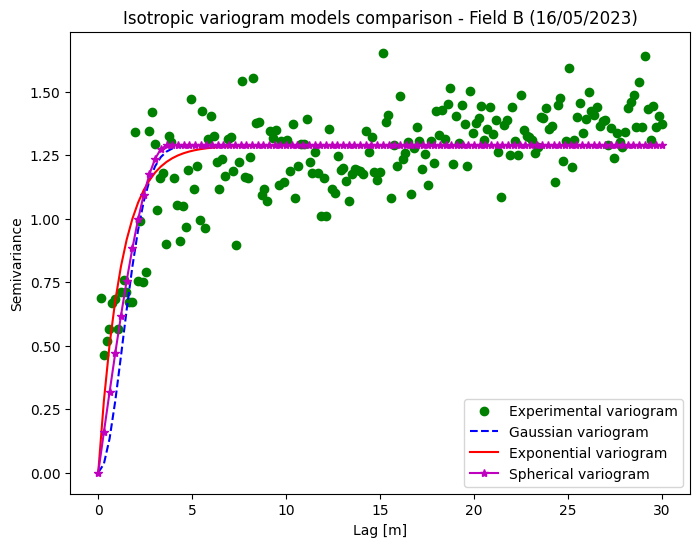

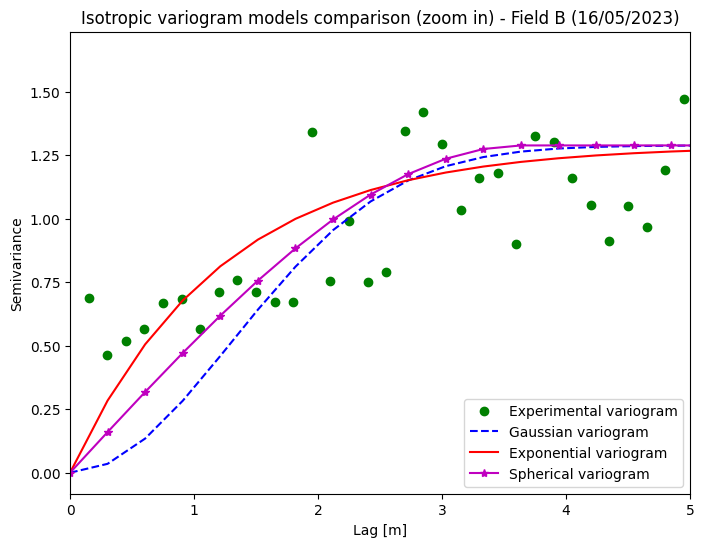

In [11]:
experimental_vario_b.fit_models()

### Kriged data

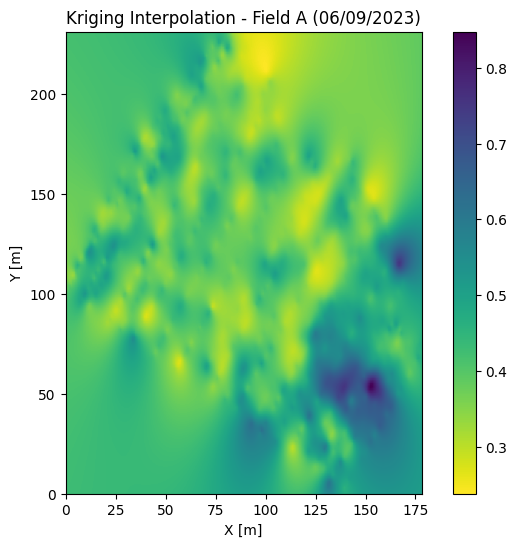

(1, 1)

In [12]:
gpr_a.kriging(x_grid_step=1, y_grid_step=1, plot=True)

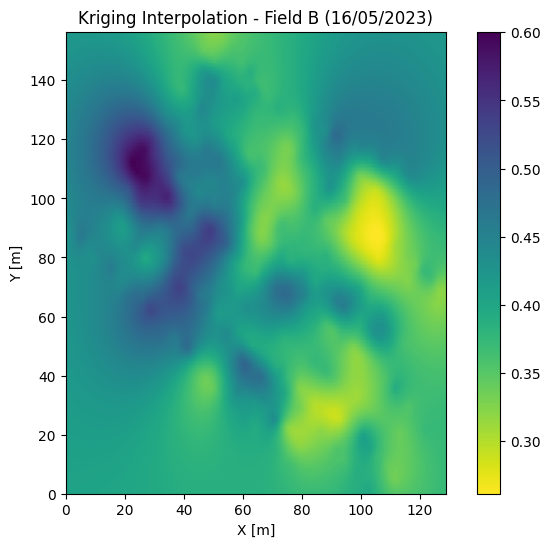

(1, 1)

In [13]:
gpr_b.kriging(x_grid_step=1, y_grid_step=1, plot=True)

## TDR Verification

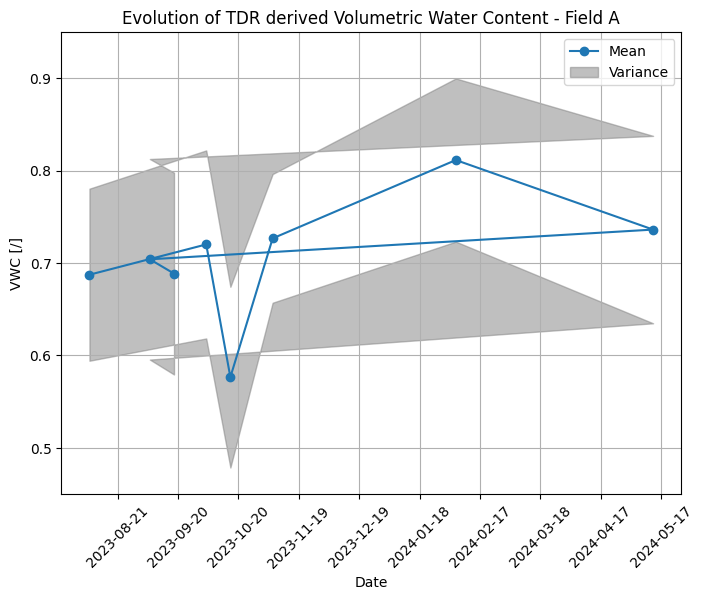

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

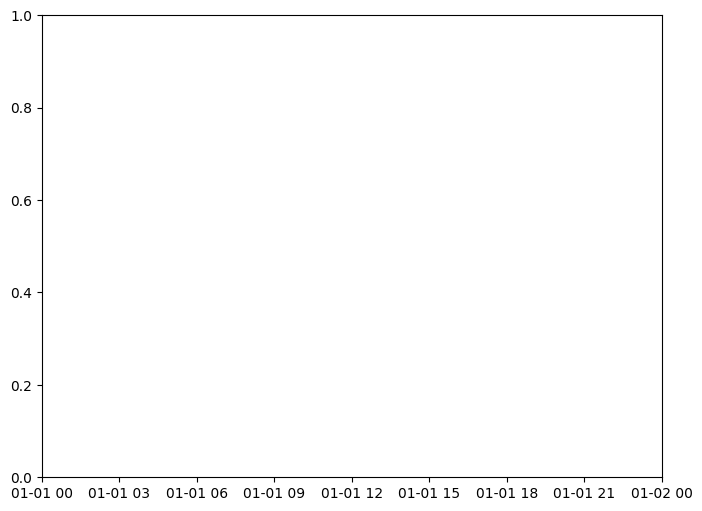

In [14]:
test = TdrAnalysis()
test.plot_tdr_evolution()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


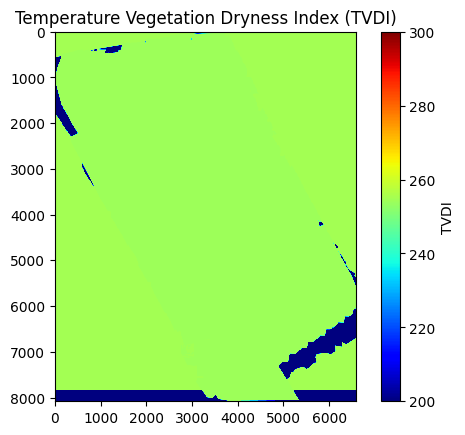

In [ ]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

multi_a.calculate_tvdi()